In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *
from utils.plots import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packag

In [3]:
# Set parameters
estimatorType='rnn' # kalman or rnn
seeAction=True
seeMeasurement=True
seeEstimate=False
seeTime=False
T=12

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           21        
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 400 samples, validate on 100 samples
Epoch 1/20
 - 21s - loss: 0.1062 - val_loss: 0.0766
Epoch 2/20
 - 15s - loss: 0.0621 - val_loss: 0.0425
Epoch 3/20
 - 16s - loss: 0.0292 - val_loss: 0.0224
Epoch 4/20
 - 19s - loss: 0.0214 - val_loss: 0.0199
Epoch 5/20
 - 17s - loss: 0.01

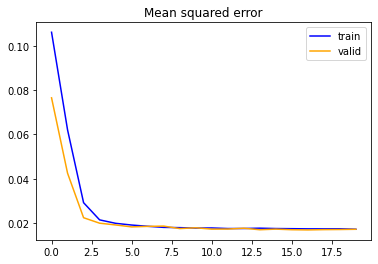

Done


In [4]:
if estimatorType=='rnn':
    # construct and train a Sequential RNN model with keras
    numberSamples_trainRNN=500
    T_trainRNN=T
    generatorType='random01'

    # generate sequences for training
    (objectives_trainRNN,measurements_trainRNN)=generateSequence(T_trainRNN,numberSamples=numberSamples_trainRNN,generatorType=generatorType)
    sigmas_trainRNN=randomSigma(T_trainRNN,numberSamples=numberSamples_trainRNN,p0=0.2)
    measurements_corrupted_trainRNN=corruptSequence_outOfRange(measurements_trainRNN,sigmas_trainRNN)

    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    history=model.fit(x=measurements_corrupted_trainRNN,y=objectives_trainRNN,batch_size=1,epochs=20,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
print('Done')

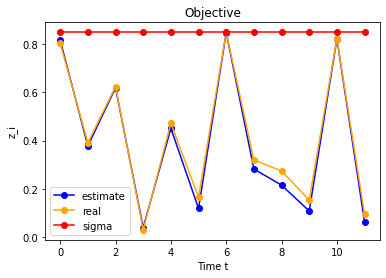

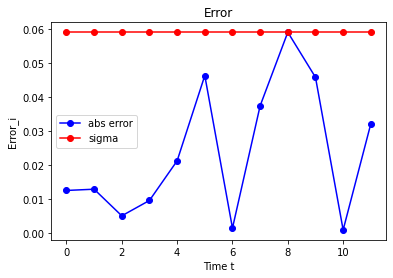

Done


In [5]:
if estimatorType=='rnn':
    idx_sample=2
    estimates_trainRNN=model.predict(measurements_corrupted_trainRNN)
    plotExperiment(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

In [6]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()
print()

# contruct rewarder
rewarder=ThresholdRewarder(threshold=2, cost=50, windowSize=4)
rewarder.summarize()

RNN estimator
  observationsDimensions: [(5,), (5, 1)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False

Threshold rewarder
  window size: 4
  threshold: 2
  cost: 50
  number of measures in the window: 0


In [7]:
# generate sequences for training and validating the agent
numberSamples_train=100
T_train=T

numberSamples_valid=numberSamples_train
T_valid=T_train

(objectives_train,measurements_train)=estimator.generateSequence(T_train,numberSamples=numberSamples_train)
(objectives_valid,measurements_valid)=estimator.generateSequence(T_valid,numberSamples=numberSamples_valid)

print('shape training objectives:',np.shape(objectives_train))
print('shape training measurements:',np.shape(measurements_train))
print('shape validating objectives:',np.shape(objectives_valid))
print('shape validating measurements:',np.shape(measurements_valid))

shape training objectives: (100, 12, 1)
shape training measurements: (100, 12, 1)
shape validating objectives: (100, 12, 1)
shape validating measurements: (100, 12, 1)


In [8]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_train,measurements_train,objectives_valid,measurements_valid)
print('Agent constructed')

Environment parameters
  inputDimensions= [(5,), (5, 1)]
Sequences parameters
  outOfRangeValue= -1
  n_dim_obj= 1
  n_dim_meas= 1
  numberSamples_train 100
  numberSamples_valid 100
RNN estimator
  observationsDimensions: [(5,), (5, 1)]
  seeAction= True
  seeMeasurement= True
  seeEstimate= False
  seeTime= False
Threshold rewarder
  window size: 4
  threshold: 2
  cost: 50
  number of measures in the window: 0
Agent constructed


In [9]:
# Train agent
agent.resumeTrainingMode() # not required
agent.run(n_epochs=100, epoch_length=numberSamples_train*T_train)
cumulatedRewards_valid=agent._controllers[2].rewards
print('Agent Trained')

Average (on the epoch) training loss: 16.98408317565918
Episode average V value: -0.030989067628979683
Average (on the epoch) training loss: 15.366456985473633
Episode average V value: -1.6284083897868793
Average (on the epoch) training loss: 12.186444282531738
Episode average V value: -1.2655481100082397
Average (on the epoch) training loss: 10.020651817321777
Episode average V value: -0.21719299225757518
Average (on the epoch) training loss: 8.322576522827148
Episode average V value: 0.31165850162506104
Average (on the epoch) training loss: 7.118772983551025
Episode average V value: -2.194891631603241
Average (on the epoch) training loss: 6.224497318267822
Episode average V value: -2.531085252761841
Average (on the epoch) training loss: 5.594804286956787
Episode average V value: -0.300680922344327
Average (on the epoch) training loss: 5.264865398406982
Episode average V value: 0.07050641626119614
Average (on the epoch) training loss: 4.966619491577148
Episode average V value: 0.15203

Average (on the epoch) training loss: 1.4179089069366455
Episode average V value: 0.024918825450268658
Average (on the epoch) training loss: 1.4100022315979004
Episode average V value: -3.3256709364553294
Average (on the epoch) training loss: 1.408917784690857
Episode average V value: -0.2749137058854103
Average (on the epoch) training loss: 1.4051344394683838
Episode average V value: -0.3070226013660431
Average (on the epoch) training loss: 1.4100606441497803
Episode average V value: 0.09703457603851955
Average (on the epoch) training loss: 1.4047287702560425
Episode average V value: -0.07934390753507614
Average (on the epoch) training loss: 1.405340552330017
Episode average V value: -0.15854889837404093
Average (on the epoch) training loss: 1.4047462940216064
Episode average V value: 0.09733012318611145
Average (on the epoch) training loss: 1.4031506776809692
Episode average V value: -0.2329045683145523
Average (on the epoch) training loss: 1.3960047960281372
Episode average V value:

Testing score per episode (id: 0) is -0.504497482786957 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.504497482786957 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.5044974827869572 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.5044974827869579 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.5044974827869572 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.504497482786958 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.5044974827869573 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.5044974827869575 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.5044974827869577 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.504497482786957 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.5044974827869577 (average over 100 episode(s))
Testing score per episode (id: 0) is -0.5044974

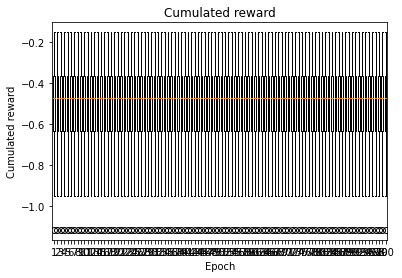

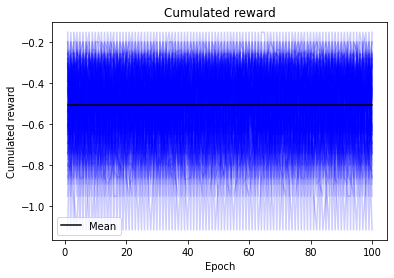

/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting

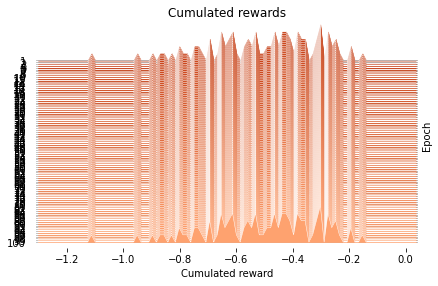

In [10]:
# plot validation
boxplotCumulatedRewards(cumulatedRewards_valid)
plotAllCumulatedRewards(cumulatedRewards_valid)
allHistoCumulatedRewards(cumulatedRewards_valid)

In [14]:
# generate test data
numberSamples_test=20
T_test=T
(objectives_test,measurements_test)=estimator.generateSequence(T_test,numberSamples=numberSamples_test)

# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)
print('Test results computed')

Test results computed


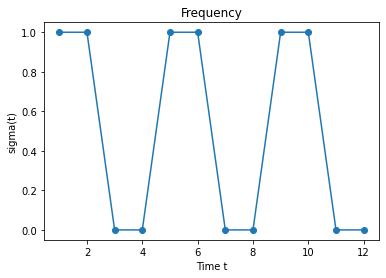

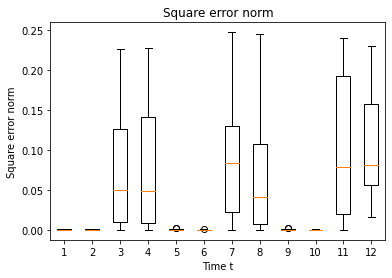

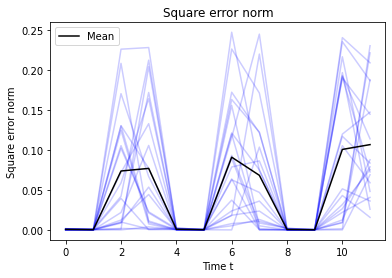

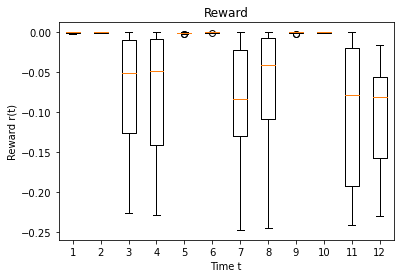

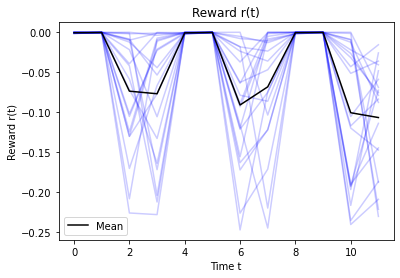

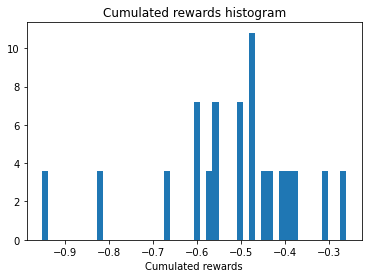

array([[1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0.],
       [1., 1., 0., 0., 1., 1.,

In [12]:
# plot test
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_test)
boxplotErrors(objectives_test,estimates_test)
plotAllErrors(objectives_test,estimates_test)
boxplotRewards(rewards_test)
plotAllRewards(rewards_test)
histoCumulatedRewards(rewards_test)
sigmas_test

In [19]:
# regular run on test data
numberMeasurements=5

# compute regular sigma (with same dim than validation data)
sigmas_regular=regularSigma(T_valid,numberMeasurements,numberSamples=numberSamples_test)

(rewards_regular, estimates_regular)=agentForcedInference(agent, sigmas_regular)
print('Done.')

Done.


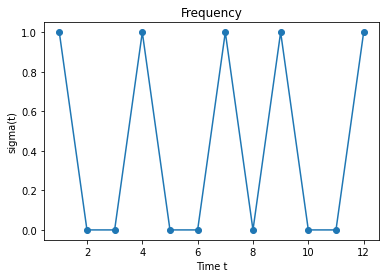

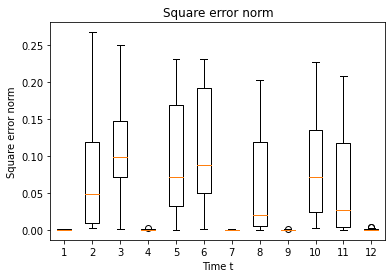

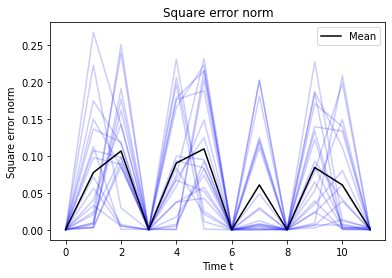

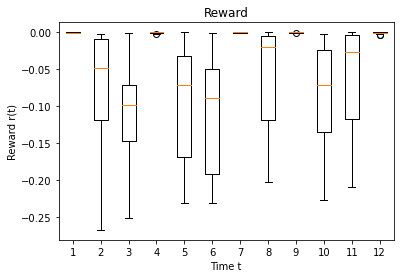

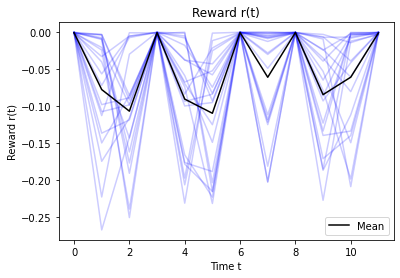

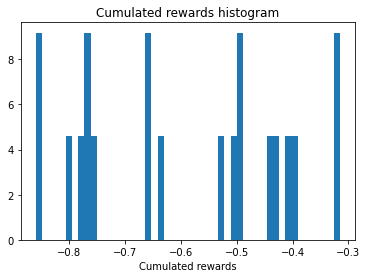

In [17]:
# plot test
idx_sample=5
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_regular)
boxplotErrors(objectives_test,estimates_regular)
plotAllErrors(objectives_test,estimates_regular)
boxplotRewards(rewards_regular)
plotAllRewards(rewards_regular)
histoCumulatedRewards(rewards_regular)

In [ ]:
import importlib
import utils.agent_treatment
importlib.reload(utils.agent_treatment)
from utils.agent_treatment import *